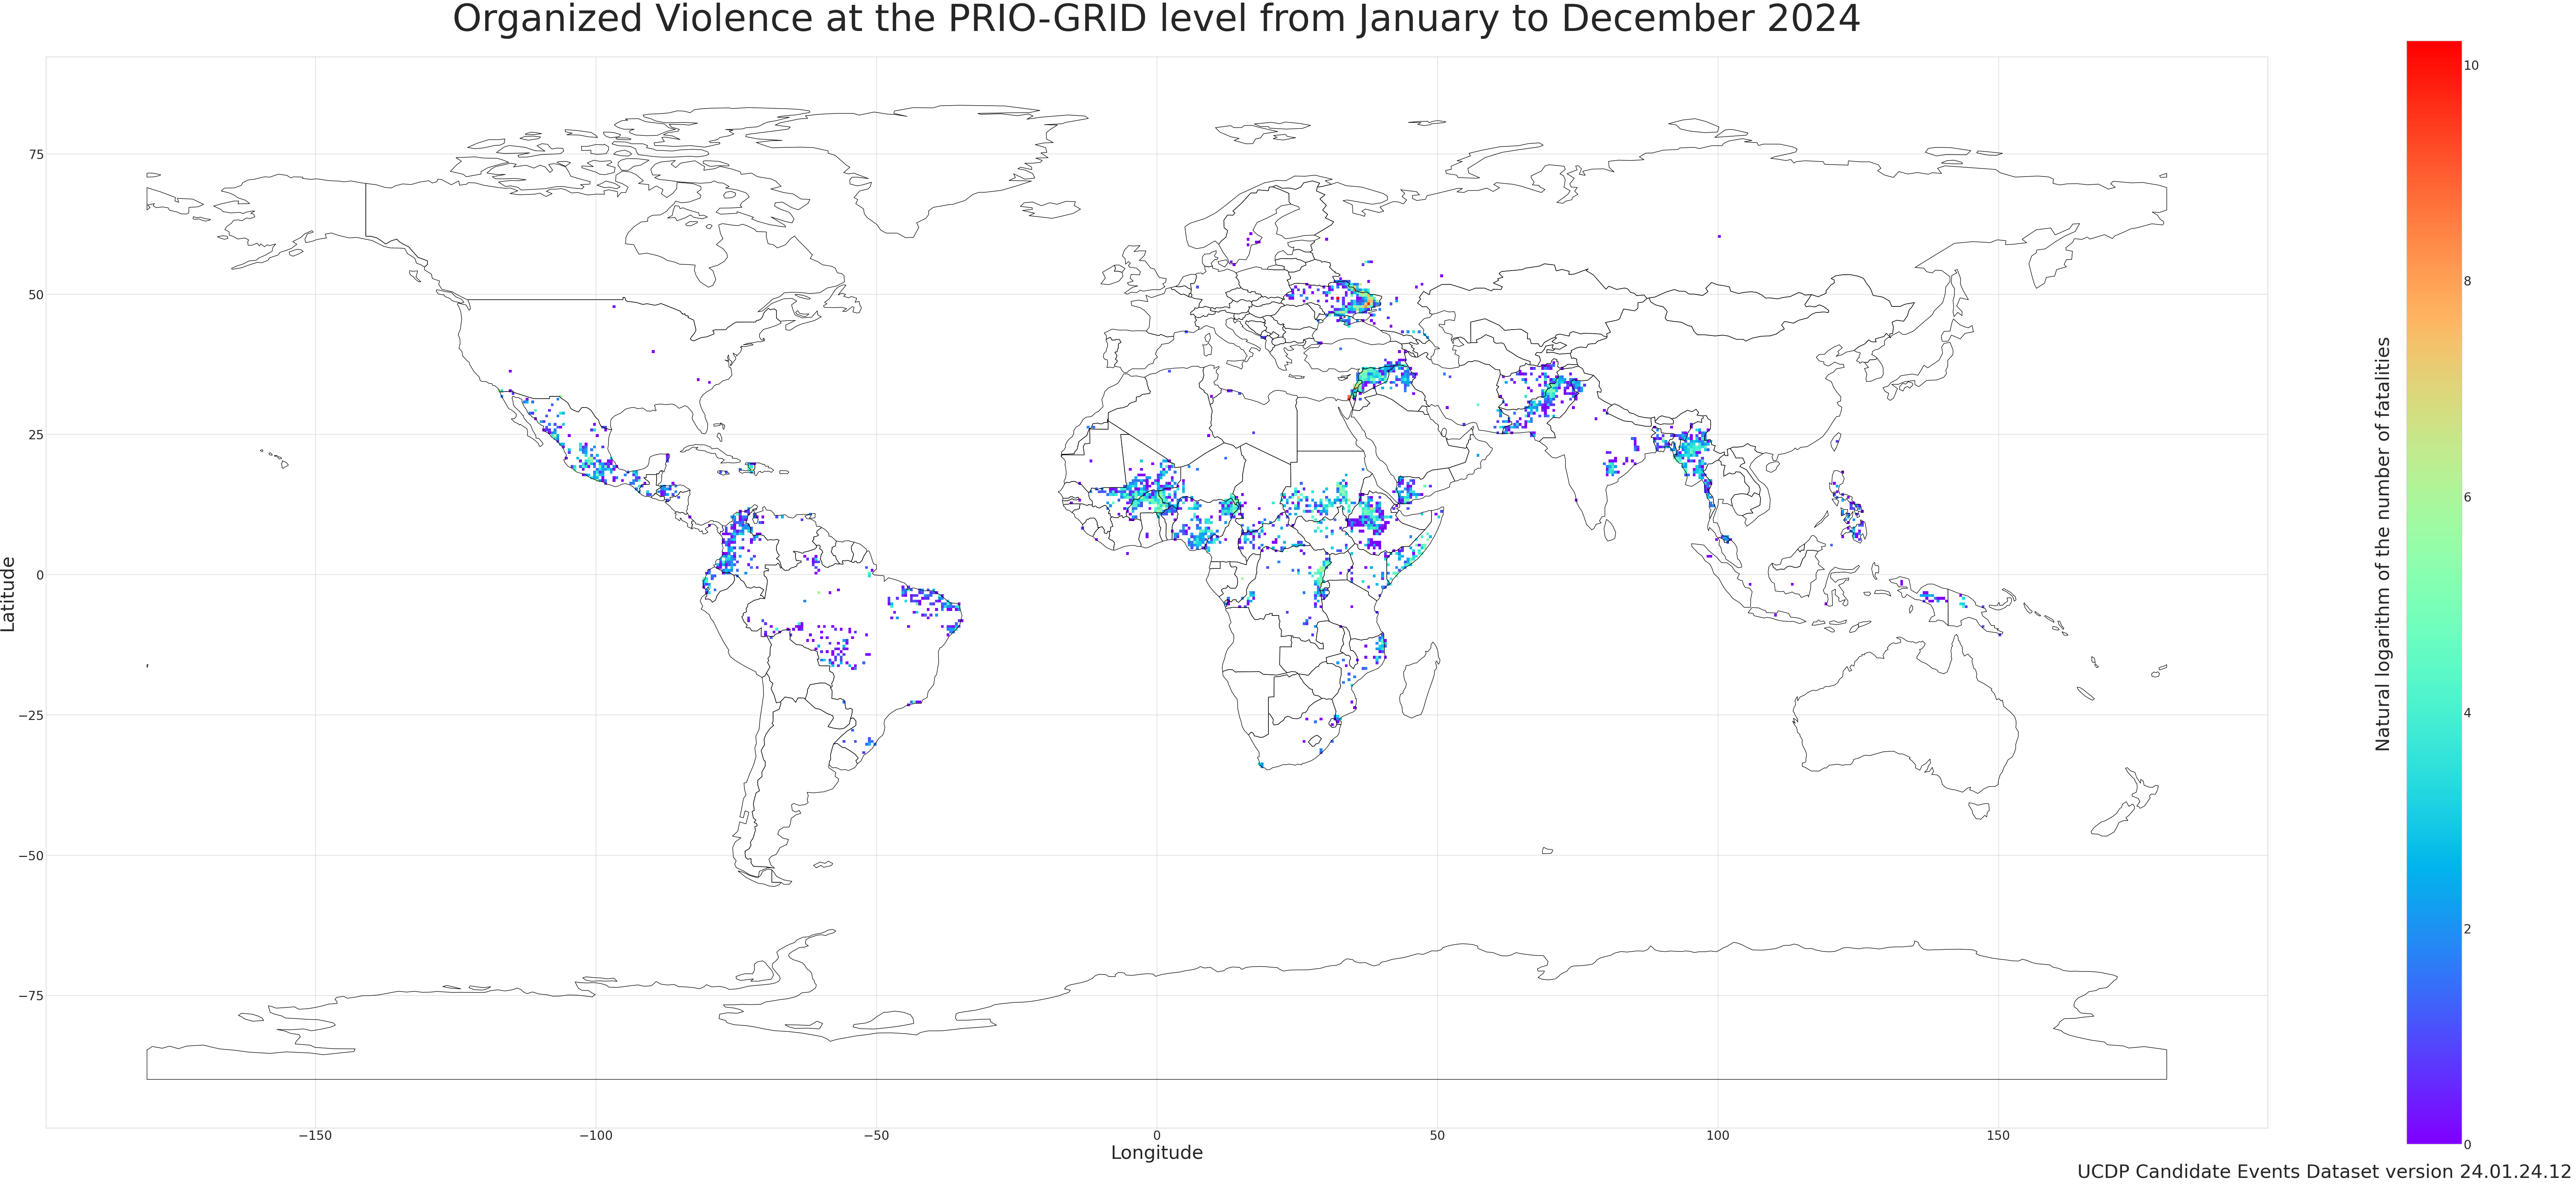

In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import os
import zipfile

def input_ucdp_version():
    return input("Enter the UCDP version: ")

def input_years_for_ged():
    return input("Enter the year or range of years for GED data (e.g., 2000 or 1989-2023): ")

def determine_version_type(version):
    segments = version.split('.')
    if len(segments) == 2:
        return "GED"
    elif len(segments) == 3:
        return "Monthly"
    elif len(segments) == 4:
        if segments[-1] == "12":
            return "Yearly"
        else:
            return "PartialYear"
    else:
        raise ValueError("Invalid UCDP version format.")

def extract_date_from_version(version, version_type):
    month_names = {
        "01": "January", "02": "February", "03": "March", "04": "April", "05": "May", 
        "06": "June", "07": "July", "08": "August", "09": "September", "10": "October", 
        "11": "November", "12": "December"
    }
    
    segments = version.split('.')
    year_str = segments[0]
    year = int(year_str) + 2000 
    end_segment = segments[-1] 

    if version_type == "Monthly":
        month = month_names[end_segment.zfill(2)]
        title = f'Organized Violence at the PRIO-GRID level in {month} {year}'
        return title
    
    elif version_type == "PartialYear":
        if end_segment == "03":
            title = f'Organized Violence at the PRIO-GRID level from January to March {year}'
        elif end_segment == "06":
            title = f'Organized Violence at the PRIO-GRID level from January to June {year}'
        elif end_segment == "09":
            title = f'Organized Violence at the PRIO-GRID level from January to September {year}'
        return title

    elif version_type == "Yearly":
        title = f'Organized Violence at the PRIO-GRID level from January to December {year}'
        start_date = f"{year}-01-01"
        end_date = f"{year}-12-31"
        return title

    elif version_type == "GED":
        return None, year

def fetch_ucdp_data_for_version(api_url):
    page = 0
    data = []
    while True:
        response = requests.get(api_url + str(page))
        page_data = response.json()
        if not page_data['Result']:
            break
        data.extend(page_data['Result'])
        page += 1
    return pd.DataFrame(data)

def fetch_fatalities_by_region(df):
    return df.groupby('region')['best'].sum()

def format_percentage_change(region, curr_fatal, prev_fatal):
    if prev_fatal == 0:  
        if curr_fatal == 0:
            return region, curr_fatal, "Similar"
        else:
            return region, curr_fatal, "Increased"
    
    change = ((curr_fatal - prev_fatal) / prev_fatal) * 100

    if -5 < change < 5:  
        change_str = f"Similar ({change:.2f}%)"
    elif change > 5:  
        change_str = f"Increased ({change:.2f}%)"
    else:  
        change_str = f"Decreased ({change:.2f}%)"

    return region, curr_fatal, change_str

def get_previous_month_version(version):
    year, _, month = version.split('.')
    year, month = int(year), int(month)
    if month == 1:
        month = 12
        year -= 1
    else:
        month -= 1
    return f"{year}.0.{month}"

# Download PRIO-Grids and read shapefile
def get_prio_grids_shapefile(prio_grids_url):
    if not os.path.exists("priogrid_cell.shp"):
        response = requests.get(prio_grids_url)
        with open("priogrid_cell.zip", "wb") as f:
            f.write(response.content)
        with zipfile.ZipFile("priogrid_cell.zip", "r") as zip_file:
            zip_file.extractall()
        os.remove("priogrid_cell.zip")
    prio_grids = gpd.read_file("priogrid_cell.shp")
    return prio_grids

def get_naturalearth_lowres():
    files_needed = ["ne_110m_admin_0_countries.shp", 
                    "ne_110m_admin_0_countries.shx", 
                    "ne_110m_admin_0_countries.dbf"]

    base_url = "https://github.com/nvkelso/natural-earth-vector/raw/master/110m_cultural/"

    if all(os.path.exists(f) for f in files_needed):
        return gpd.read_file("ne_110m_admin_0_countries.shp")

    for file_name in files_needed:
        file_path = os.path.join(base_url, file_name)
        if not os.path.exists(file_name):
            response = requests.get(file_path)
            if response.status_code == 200:
                with open(file_name, "wb") as f:
                    f.write(response.content)
            else:
                print(f"Failed to download {file_name}: Status code {response.status_code}")
                return None

    return gpd.read_file("ne_110m_admin_0_countries.shp")

def generate_monthly_map(version, title, ucdp_data, previous_ucdp_data, version_type):
    current_fatalities = fetch_fatalities_by_region(ucdp_data)
    previous_fatalities = fetch_fatalities_by_region(previous_ucdp_data)

    regions = ['Asia', 'Africa', 'Middle East', 'Americas', 'Europe']

    fact_box_data = [
        [f"Total number of fatalities", f"{ucdp_data['best'].sum()}"],
        ["Number of candidate events", f"{len(ucdp_data)}"]
    ]

    # Create a list to store the rows of the table
    table_data = []
    for region in regions:
        curr_fatal = current_fatalities.get(region, 0)
        prev_fatal = previous_fatalities.get(region, 0)
        region_name, curr_fatal, change_str = format_percentage_change(region, curr_fatal, prev_fatal)
        table_data.append([region_name, curr_fatal, change_str])

    world_map = get_naturalearth_lowres()

    prio_grids_url = "https://grid.prio.org/extensions/priogrid_cellshp.zip"
    prio_grids = get_prio_grids_shapefile(prio_grids_url)
    ucdp_temp = ucdp_data.groupby(by=['priogrid_gid'])['best'].sum()
    merged_data = prio_grids.merge(ucdp_temp, left_on="gid", right_on="priogrid_gid")

    with plt.style.context(("seaborn-v0_8-white", "seaborn-v0_8-whitegrid")):
        fig, ax1 = plt.subplots(figsize=(96, 64))

        plt.xticks(fontsize=24)
        plt.yticks(fontsize=24)

        merged_data["log_best"] = np.log(merged_data["best"].clip(lower=1))
        merged_data.plot(column="log_best",
                         ax=ax1,
                         legend=True,
                         legend_kwds={'shrink': 0.60},
                         cmap=plt.cm.rainbow).figure.axes[1].tick_params(labelsize=24)
        ax1.set_title(title, pad=50, size=72)
        ax1.set_ylabel('Latitude', fontsize=36)
        ax1.set_xlabel('Longitude', fontsize=36)

        world_map.plot(facecolor="none",
                       ax=ax1,
                       edgecolor="black")

        # Adding the fact box as a table to the plot
        fact_box_table = ax1.table(cellText=fact_box_data, fontsize=36, loc='lower left', cellLoc='center', zorder=6)
        fact_box_table.auto_set_font_size(False)
        fact_box_table.set_fontsize(36)
        fact_box_table.scale(0.3, 5)

        # Adding the table to the plot
        table_columns = ['Region', 'Number of fatalities', 'Change since last month']
        table = ax1.table(cellText=table_data, colLabels=table_columns, fontsize=36, loc='lower right', cellLoc='center', zorder=6)
        table.auto_set_font_size(False)
        table.set_fontsize(36)
        table.scale(0.3, 5)
        table.auto_set_column_width(col=list(range(len(table_columns)))) # Adjust column width

        plt.figtext(0.78, 0.43, "Natural logarithm of the number of fatalities", rotation='vertical', ha="right", fontsize=36)
        plt.figtext(0.83, 0.25, f"UCDP Candidate Events Dataset version {version}", ha="right", fontsize=36)
        plt.rcParams['font.family'] = 'Open Sans'

        fig.savefig(f'GEDEvent_v{version.replace(".", "_")}.pdf', bbox_inches='tight', pad_inches=5)

def generate_map(version, title, ucdp_data, version_type, years=None):
    world_map = get_naturalearth_lowres()

    prio_grids_url = "https://grid.prio.org/extensions/priogrid_cellshp.zip"
    prio_grids = get_prio_grids_shapefile(prio_grids_url)
    ucdp_temp = ucdp_data.groupby(by=['priogrid_gid'])['best'].sum()
    merged_data = prio_grids.merge(ucdp_temp, left_on="gid", right_on="priogrid_gid")

    with plt.style.context(("seaborn-v0_8-white", "seaborn-v0_8-whitegrid")):
        fig, ax1 = plt.subplots(figsize=(96, 64))

        plt.xticks(fontsize=24)
        plt.yticks(fontsize=24)

        merged_data["log_best"] = np.log(merged_data["best"].clip(lower=1))
        merged_data.plot(column="log_best",
                         ax=ax1,
                         legend=True,
                         legend_kwds={'shrink': 0.60},
                         cmap=plt.cm.rainbow).figure.axes[1].tick_params(labelsize=24)
        ax1.set_title(title, pad=50, size=72) 
        ax1.set_ylabel('Latitude', fontsize=36)
        ax1.set_xlabel('Longitude', fontsize=36)

        world_map.plot(facecolor="none",
                       ax=ax1,
                       edgecolor="black")

        if version_type == "GED":
            footer_text = f"UCDP Georeferenced Event Dataset version {version}"
        else:
            footer_text = f"UCDP Candidate Events Dataset version {version}"

        plt.figtext(0.78, 0.43, "Natural logarithm of the number of fatalities", rotation='vertical', ha="right", fontsize=36)
        plt.figtext(0.83, 0.25, footer_text, ha="right", fontsize=36)

        plt.rcParams['font.family'] = 'Open Sans'

        if version_type == "GED":
            fig.savefig(f'GEDEvent_v{version.replace(".", "_")}_{years}.pdf', bbox_inches='tight', pad_inches=5)
        else:
            fig.savefig(f'GEDEvent_v{version.replace(".", "_")}.pdf', bbox_inches='tight', pad_inches=5)

def main():
    version = input_ucdp_version()
    version_type = determine_version_type(version)

    if version_type == "Monthly":
        title = extract_date_from_version(version, version_type)
        ucdp_api_url = f"https://ucdpapi.pcr.uu.se/api/gedevents/{version}?pagesize=100000&page="
        ucdp_data = fetch_ucdp_data_for_version(ucdp_api_url)

        # Fetching previous month's data for comparison
        previous_version = get_previous_month_version(version)
        previous_ucdp_api_url = f"https://ucdpapi.pcr.uu.se/api/gedevents/{previous_version}?pagesize=100000&page="
        previous_ucdp_data = fetch_ucdp_data_for_version(previous_ucdp_api_url)
        
        generate_monthly_map(version, title, ucdp_data, previous_ucdp_data, version_type)
    
    elif version_type == "PartialYear":
        title = extract_date_from_version(version, version_type)
        ucdp_api_url = f"https://ucdpapi.pcr.uu.se/api/gedevents/{version}?pagesize=100000&page="
        ucdp_data = fetch_ucdp_data_for_version(ucdp_api_url)
        
        generate_map(version, title, ucdp_data, version_type)
    
    elif version_type == "Yearly":
        title = extract_date_from_version(version, version_type)
        ucdp_api_url = f"https://ucdpapi.pcr.uu.se/api/gedevents/{version}?pagesize=100000&page="
        ucdp_data = fetch_ucdp_data_for_version(ucdp_api_url)
        
        generate_map(version, title, ucdp_data, version_type)
    
    elif version_type == "GED":
        years = input_years_for_ged()
        if '-' in years:
            start_year, end_year = years.split('-')
            title = f'Organized Violence at the PRIO-GRID level from {start_year} to {end_year}'
            ucdp_api_url = f"https://ucdpapi.pcr.uu.se/api/gedevents/{version}?pagesize=100000&StartDate={start_year}-01-01&EndDate={end_year}-12-31&page="
        else:
            title = f'Organized Violence at the PRIO-GRID level in {years}'
            ucdp_api_url = f"https://ucdpapi.pcr.uu.se/api/gedevents/{version}?pagesize=100000&StartDate={years}-01-01&EndDate={years}-12-31&page="
        
        ucdp_data = fetch_ucdp_data_for_version(ucdp_api_url)

        generate_map(version, title, ucdp_data, version_type, years=years)

if __name__ == "__main__":
    main()

plt.show()